## 1-D Toy Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

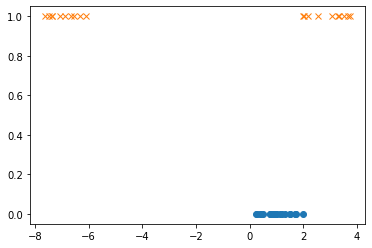

In [2]:
x_0 = np.random.rand(20,1)*2
x_1_1 = np.random.rand(10,1)*2+2
x_1_2 = np.random.rand(10,1)*2-8
x_1 = np.concatenate((x_1_1,x_1_2))

data = np.concatenate((x_0,x_1))
target = np.concatenate((np.zeros((20,1))-1,np.ones((20,1))))

plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.show()

In [3]:
def covariance_function(x1,x2,length,signal_var,noise_var):
    size1 = x1.shape[0]
    size2 = x2.shape[0]
    out = np.zeros((size1,size2))
    for i in range(size1):
        for j in range(size2): 
            xp = x1[i]
            xq = x2[j]
            out[i,j] =signal_var * math.exp(-1/2*(abs(xp-xq)**2)/length)+noise_var*(i==j)
    return out

## Laplace Approximation

In [4]:
def logit_function(x):
    return 1/(1+np.exp(-x))

In [5]:
f = np.zeros_like(target)
K = covariance_function(data,data,1,1,0.1)
K_inv = np.linalg.inv(K)

In [6]:
error = 100
while error>1e-6:
    pi = logit_function(f)
    W = np.zeros((f.shape[0],f.shape[0]))
    temp = (pi*(1-pi)).reshape(-1).tolist()
    np.fill_diagonal(W,temp)
    dp = (target+1)/2 - pi
    cov = np.linalg.inv(K_inv+W)
    f_new = np.matmul(cov,np.matmul(W,f)+dp)
    error = np.sum(np.abs(f_new-f))
    print(error)
    f = f_new
f_hat = f

50.84825597339089
7.244310388841113
0.38575079326794337
0.001410342520087371
2.1776647637916646e-08


In [7]:
x_star = np.linspace(-9,5,200)
k_star = covariance_function(data,x_star,1,1,0.1)
predicted_mean = np.matmul(np.matmul(k_star.T,K_inv),f_hat)
predicted_var = covariance_function(x_star,x_star,1,1,0.1) - np.matmul(np.matmul(k_star.T,cov),k_star)

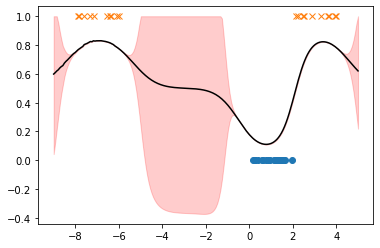

In [10]:
logit_predicted_mean = logit_function(predicted_mean).reshape(-1)
a = predicted_var.diagonal()
a = logit_function(a)
a = np.sqrt(a)
plt.figure()
plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.plot(x_star.reshape(-1),logit_predicted_mean,color='k')
plt.fill_between(x_star.reshape(-1), (logit_predicted_mean-a).clip(-0.5,1.5),(logit_predicted_mean+a).clip(-0.5,1.5),alpha=0.2,color='r')
plt.show()

## Expectation Propagation

In [52]:
f = np.zeros_like(target)
K = covariance_function(data,data,1,1,0)
K_inv = np.linalg.inv(K)

In [53]:
import scipy.stats
import copy
NormalDistribution=scipy.stats.norm(0, 1)

In [54]:
K

array([[1.00000000e+00, 9.99393902e-01, 9.75096793e-01, ...,
        9.83689614e-19, 5.43503789e-16, 1.43180779e-17],
       [9.99393902e-01, 1.00000000e+00, 9.82156661e-01, ...,
        1.34992604e-18, 7.27336037e-16, 1.94453194e-17],
       [9.75096793e-01, 9.82156661e-01, 1.00000000e+00, ...,
        7.41468981e-18, 3.48348242e-15, 1.00915586e-16],
       ...,
       [9.83689614e-19, 1.34992604e-18, 7.41468981e-18, ...,
        1.00000000e+00, 7.70535147e-01, 9.56288261e-01],
       [5.43503789e-16, 7.27336037e-16, 3.48348242e-15, ...,
        7.70535147e-01, 1.00000000e+00, 9.14399748e-01],
       [1.43180779e-17, 1.94453194e-17, 1.00915586e-16, ...,
        9.56288261e-01, 9.14399748e-01, 1.00000000e+00]])

In [58]:
error = 100
mu = np.zeros((data.shape[0],1))
sigma = copy.deepcopy(K)


mu_last = np.zeros((data.shape[0],1))
sigma_last = copy.deepcopy(K)

nu_tilda = np.zeros((data.shape[0],1))
tau_tilda = np.zeros(data.shape[0])

# mu_tilda_new = np.zeros((data.shape[0],1))
# sigma_tilda_new = np.ones(data.shape[0])

# sigma_minus = np.zeros(data.shape[0])
# mu_minus = np.zeros(data.shape[0])

# sigma_hat = np.zeros(data.shape[0])
# mu_hat = np.zeros(data.shape[0])
while error>1e-6:
    for i in range(0,data.shape[0]):
        sigma_i = sigma[i,i]**(0.5)
        tau_minus = sigma_i**(-2) - tau_tilda[i]
        nu_minus = sigma_i**(-2)*mu[i] - nu_tilda[i]
        sigma_minus = tau_minus**(-0.5)
        # print('a',sigma_minus)
        mu_minus = nu_minus / tau_minus
        z_i = (target[i]*mu_minus)/math.sqrt(1+sigma_minus**2)
        mu_hat_i = mu_minus + (NormalDistribution.pdf(z_i)*target[i]*sigma_minus**2) \
                                    /(NormalDistribution.cdf(z_i)*math.sqrt(1+sigma_minus**2))

        sigma_hat_i = sigma_minus**(2) - sigma_minus**(4)*NormalDistribution.pdf(z_i)/ \
                            ((1+sigma_minus**(2))*NormalDistribution.cdf(z_i))* \
                             (z_i+NormalDistribution.pdf(z_i)/NormalDistribution.cdf(z_i))
        sigma_hat_i = sigma_hat_i**(0.5)
        
        dtau_tilda = sigma_hat_i**(-2) - tau_minus - tau_tilda[i]
        tau_tilda[i] = tau_tilda[i] + dtau_tilda
        nu_tilda[i] = sigma_hat_i**(-2)*mu_hat_i - nu_minus
        s_i = copy.deepcopy(sigma[:,i]).reshape(-1,1)
        temp =((dtau_tilda)**(-1)+sigma[i,i])**(-1)*np.matmul(s_i,s_i.T)
        sigma -= temp
        # print(sigma)
        mu = np.dot(sigma,nu_tilda)
        # print(mu)

    S = np.eye(data.shape[0])*tau_tilda
    simga = K - np.dot(K, np.dot(np.linalg.inv((K + np.linalg.inv(S))), K))
    mu = np.dot(sigma, nu_tilda)

    error = np.sum(np.abs(mu_last - mu))+ np.sum(np.abs(sigma-sigma_last))
    sigma_last = sigma
    mu_last = mu
    print(error)
    

532.8328296773801
0.7883024044471794
0.13761931601676614
0.010720613630931686
0.0006638981086212054
6.117012177878078e-05
4.925638633176965e-06
3.5560098347875435e-07


In [59]:
x_star = np.linspace(-9,5,200)
k_star = covariance_function(data,x_star,1,1,0.1)

In [87]:
S = np.eye(data.shape[0])* tau_tilda
sigma_tilda = np.linalg.inv(S)

predicted_mean = np.dot(np.dot(k_star.T,np.eye(data.shape[0]) - 
                    np.dot(np.linalg.inv(K+sigma_tilda),K)), nu_tilda)
                    
predicted_var = covariance_function(x_star,x_star,1,1,0) - np.matmul(np.matmul(k_star.T,\
                                                            np.linalg.inv(K+sigma_tilda)),k_star)

In [90]:

f_star = NormalDistribution.cdf(predicted_mean).reshape(-1)#.diagonal(),
a = predicted_var.diagonal()


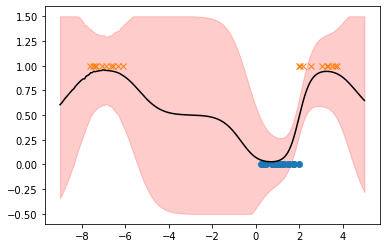

In [92]:
plt.figure()
plt.plot(x_0,[0]*x_0.shape[0],'o')
plt.plot(x_1,[1]*x_1.shape[0],'x')
plt.plot(x_star.reshape(-1),f_star,color='k')
plt.fill_between(x_star.reshape(-1), (f_star-a).clip(-0.5,1.5),(f_star+a).clip(-0.5,1.5),alpha=0.2,color='r')
plt.show()